In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import glob
from astropy.table import Table
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from astroquery.mast import Tesscut
from astroquery.mast import Catalogs
import matplotlib.pyplot as plt
import lightkurve
from scipy.signal import find_peaks

plt.style.use("seaborn-white")






# Cross reference with TESS Sectors

In [2]:
# Collect list of stellar parameter files
stellar_param_files = glob.glob("pydata/sumout_files/*")

In [3]:
# Generate Stellar Parameter DataFrame
stellar_param_dict = {}
files = ["pydata/sumout_files/11Com_2012.m.sumout"]
for file in stellar_param_files:
    with open(file,'r') as f:
        for i, line in enumerate(f):
            if i == 0:
                star = f.readline().split(" ")[0].split("_")[0] # fix this for ngc
                #print(star)
                params = [elem for elem in f.readline().split(" ") if elem != '']
                #print(params)
                metallicity = params[-2]
                if '-' in metallicity:
                    metallicity = metallicity[4:]
                file_dict = {'Teff': float(params[2]), 'Log_g':float(params[6]), 'M/H':float(metallicity)}
                #print(file_dict)
                stellar_param_dict[star] = file_dict
                
param_df = pd.DataFrame.from_dict(stellar_param_dict, orient='index')

In [4]:
stars = list(param_df.index)
print(stars)

param_df.loc[stars[0]]

['11Com', '18Del', '24Sex', '7CMa', '81Cet', 'AlphaAri', 'BD+12', 'BD+20274', 'GammaLeoA', 'HD100655', 'HD102272', 'HD102329', 'HD105096', 'HD108863', 'HD108991', 'HD115202', 'HD116029', 'HD118082', 'HD11977', 'HD121056', 'HD121156', 'HD123239', 'HD125217', 'HD126105', 'HD131496', 'HD1502', 'HD1690', 'HD17311', 'HD175541', 'HD176884', 'HD180902', 'HD181342', 'HD18742', 'HD188105', 'HD19138', 'HD192699', 'HD194937', 'HD19810', 'HD198599', 'HD200964', 'HD203638', 'HD205478', 'HD206610', 'HD20924', 'HD210702', 'HD212771', 'HD213066', 'HD21340', 'HD219553', 'HD233860', 'HD24148', 'HD24316', 'HD25069', 'HD28678', 'HD30128', 'HD30856', 'HD31693', 'HD31860', 'HD33142', 'HD33240', 'HD34909', 'HD39079', 'HD4313', 'HD45433', 'HD5319', 'HD58540', 'HD5877', 'HD5891', 'HD6037', 'HD64152', 'HD6665', 'HD68776', 'HD72292', 'HD73534', 'HD76321', 'HD84561', 'HD94386', 'HD95089', 'HD96036', 'HD96683', 'HD98219', 'HD98516', 'HD98579', 'HIP113622', 'HIP117756', 'Tyc0017-01084-1', 'Tyc0683-01190-1', 'Tyc120

Teff     4810.00
Log_g       2.51
M/H        -0.28
Name: 11Com, dtype: float64

### TESS Queries

In [5]:
# Example Query

target_name = "HD209458"
search_radius_deg = 0.05

catalogTIC = Catalogs.query_object(target_name, radius=search_radius_deg, catalog="TIC")
where_closest = np.argmin(catalogTIC['dstArcSec'])
print("Closest TIC ID to %s: TIC %s, separation of %f arcsec. and a TESS mag. of %f"%
      (target_name, catalogTIC['ID'][where_closest], catalogTIC['dstArcSec'][where_closest],
      catalogTIC['Tmag'][where_closest]))

print(catalogTIC.colnames)
#print(catalogTIC['Teff'][where_closest])

Closest TIC ID to HD209458: TIC 420814525, separation of 0.173474 arcsec. and a TESS mag. of 7.105000
['ID', 'ra', 'dec', 'pmRA', 'pmDEC', 'Tmag', 'objType', 'typeSrc', 'version', 'HIP', 'TYC', 'UCAC', 'TWOMASS', 'SDSS', 'ALLWISE', 'GAIA', 'APASS', 'KIC', 'POSflag', 'e_pmRA', 'e_pmDEC', 'PMflag', 'plx', 'e_plx', 'PARflag', 'gallong', 'gallat', 'eclong', 'eclat', 'Bmag', 'e_Bmag', 'Vmag', 'e_Vmag', 'umag', 'e_umag', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 'zmag', 'e_zmag', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag', 'e_Kmag', 'TWOMflag', 'prox', 'w1mag', 'e_w1mag', 'w2mag', 'e_w2mag', 'w3mag', 'e_w3mag', 'w4mag', 'e_w4mag', 'GAIAmag', 'e_GAIAmag', 'e_Tmag', 'TESSflag', 'SPFlag', 'Teff', 'e_Teff', 'logg', 'e_logg', 'MH', 'e_MH', 'rad', 'e_rad', 'mass', 'e_mass', 'rho', 'e_rho', 'lumclass', 'lum', 'e_lum', 'd', 'e_d', 'ebv', 'e_ebv', 'numcont', 'contratio', 'disposition', 'duplicate_id', 'priority', 'dstArcSec']


In [7]:
# Generate Comparison Dictionary

comp_dict = {}

search_radius_deg=0.05
for star in stars:
    target_name = star
    if target_name == "AlphaAri":
        target_name = "HD12929"
    elif target_name == "GammaLeoA":
        target_name = "HD89484"
    elif target_name == "xiAql":
        target_name = "HD188310"
        
    try:
        catalogTIC = Catalogs.query_object(target_name, radius=search_radius_deg, catalog="TIC")
        where_closest = np.argmin(catalogTIC['dstArcSec'])
        #print("Closest TIC ID to %s: TIC %s, separation of %f arcsec. and a TESS mag. of %f"%
        #     (target_name, catalogTIC['ID'][where_closest], catalogTIC['dstArcSec'][where_closest],
        #      catalogTIC['Tmag'][where_closest]))
        if catalogTIC['dstArcSec'][where_closest] >= 0.4: # Ignore anything off by more than 0.4 arcseconds
            continue
        
        # Get the TESS sectors in which the object has been observed (if any)
        cameras = []
        sectors = []
        ccds = []
        sector_Table = Tesscut.get_sectors(star) # Get the TESS sectors in which the object has been observed (if any)
        if len(sector_Table) != 0:
            for i in range(len(sector_Table)):
                cameras.append(sector_Table[i][2])
                sectors.append(sector_Table[i][1])
                ccds.append(sector_Table[i][3])
        
        star_dict = {"TIC":catalogTIC['ID'][where_closest],
                     "TESS_cameras":cameras,
                     "TESS_sectors":sectors,
                     "TESS_ccds":ccds,
                     "meas_Teff": param_df.loc[star]["Teff"],
                     "meas_logg": param_df.loc[star]["Log_g"],
                     "meas_MH": param_df.loc[star]["M/H"],
                     "TESS_Teff": catalogTIC['Teff'][where_closest], 
                     "TESS_e_Teff": catalogTIC['e_Teff'][where_closest],
                     "TESS_logg": catalogTIC['logg'][where_closest],
                     "TESS_e_logg": catalogTIC['e_logg'][where_closest],
                     "TESS_MH": catalogTIC['MH'][where_closest],
                     "TESS_e_MH": catalogTIC['e_MH'][where_closest]}
        
        comp_dict[star] = star_dict
        
            
    except:
        print("No match found for {}".format(target_name))

comp_df = pd.DataFrame.from_dict(comp_dict, orient='index')
comp_df = comp_df[['TIC',"TESS_sectors", "TESS_cameras", "TESS_ccds", "meas_Teff", "TESS_Teff", 
                   'TESS_e_Teff',"meas_logg","TESS_logg","TESS_e_logg","meas_MH","TESS_MH", "TESS_e_MH"]]

No match found for HD12929
No match found for BD+12
No match found for HD89484
No match found for epsRet
No match found for epsTau
No match found for epsilonRet
No match found for HD188310


In [8]:
#comp_df # Comparison Dictionary

In [9]:
# Get the subsets of comp_df that has TESS measurements and errors for the various stellar parameters

mask = [type(element) != np.ma.core.MaskedConstant for element in np.array(comp_df['TESS_e_Teff'])]
teff_df = comp_df[mask]

mask = [type(element) != np.ma.core.MaskedConstant for element in np.array(comp_df['TESS_e_logg'])]
logg_df = comp_df[mask]

# M/H has an entry with an uncertainty but no measurement so we need to double up on masks here
mask_e = [type(element) != np.ma.core.MaskedConstant for element in np.array(comp_df['TESS_e_MH'])]
mask_val = [type(element) != np.ma.core.MaskedConstant for element in np.array(comp_df['TESS_MH'])]
mask = np.array(mask_e) * np.array(mask_val)
MH_df = comp_df[mask]

print("Teff matches: {}".format(len(teff_df)),
      "logg matches: {}".format(len(logg_df)), 
      "M/H matches: {}".format(len(MH_df)))

print("Median Temperature Difference: {}".format(np.median(abs(teff_df['meas_Teff'] - teff_df['TESS_Teff']))))
print("Median Logg Difference: {}".format(np.median(abs(logg_df['meas_logg'] - logg_df['TESS_logg']))))
print("Median M/H Difference: {}".format(np.median(abs(MH_df['meas_MH'] - MH_df['TESS_MH']))))


Teff matches: 40 logg matches: 37 M/H matches: 21
Median Temperature Difference: 80.5
Median Logg Difference: 0.35792
Median M/H Difference: 0.09


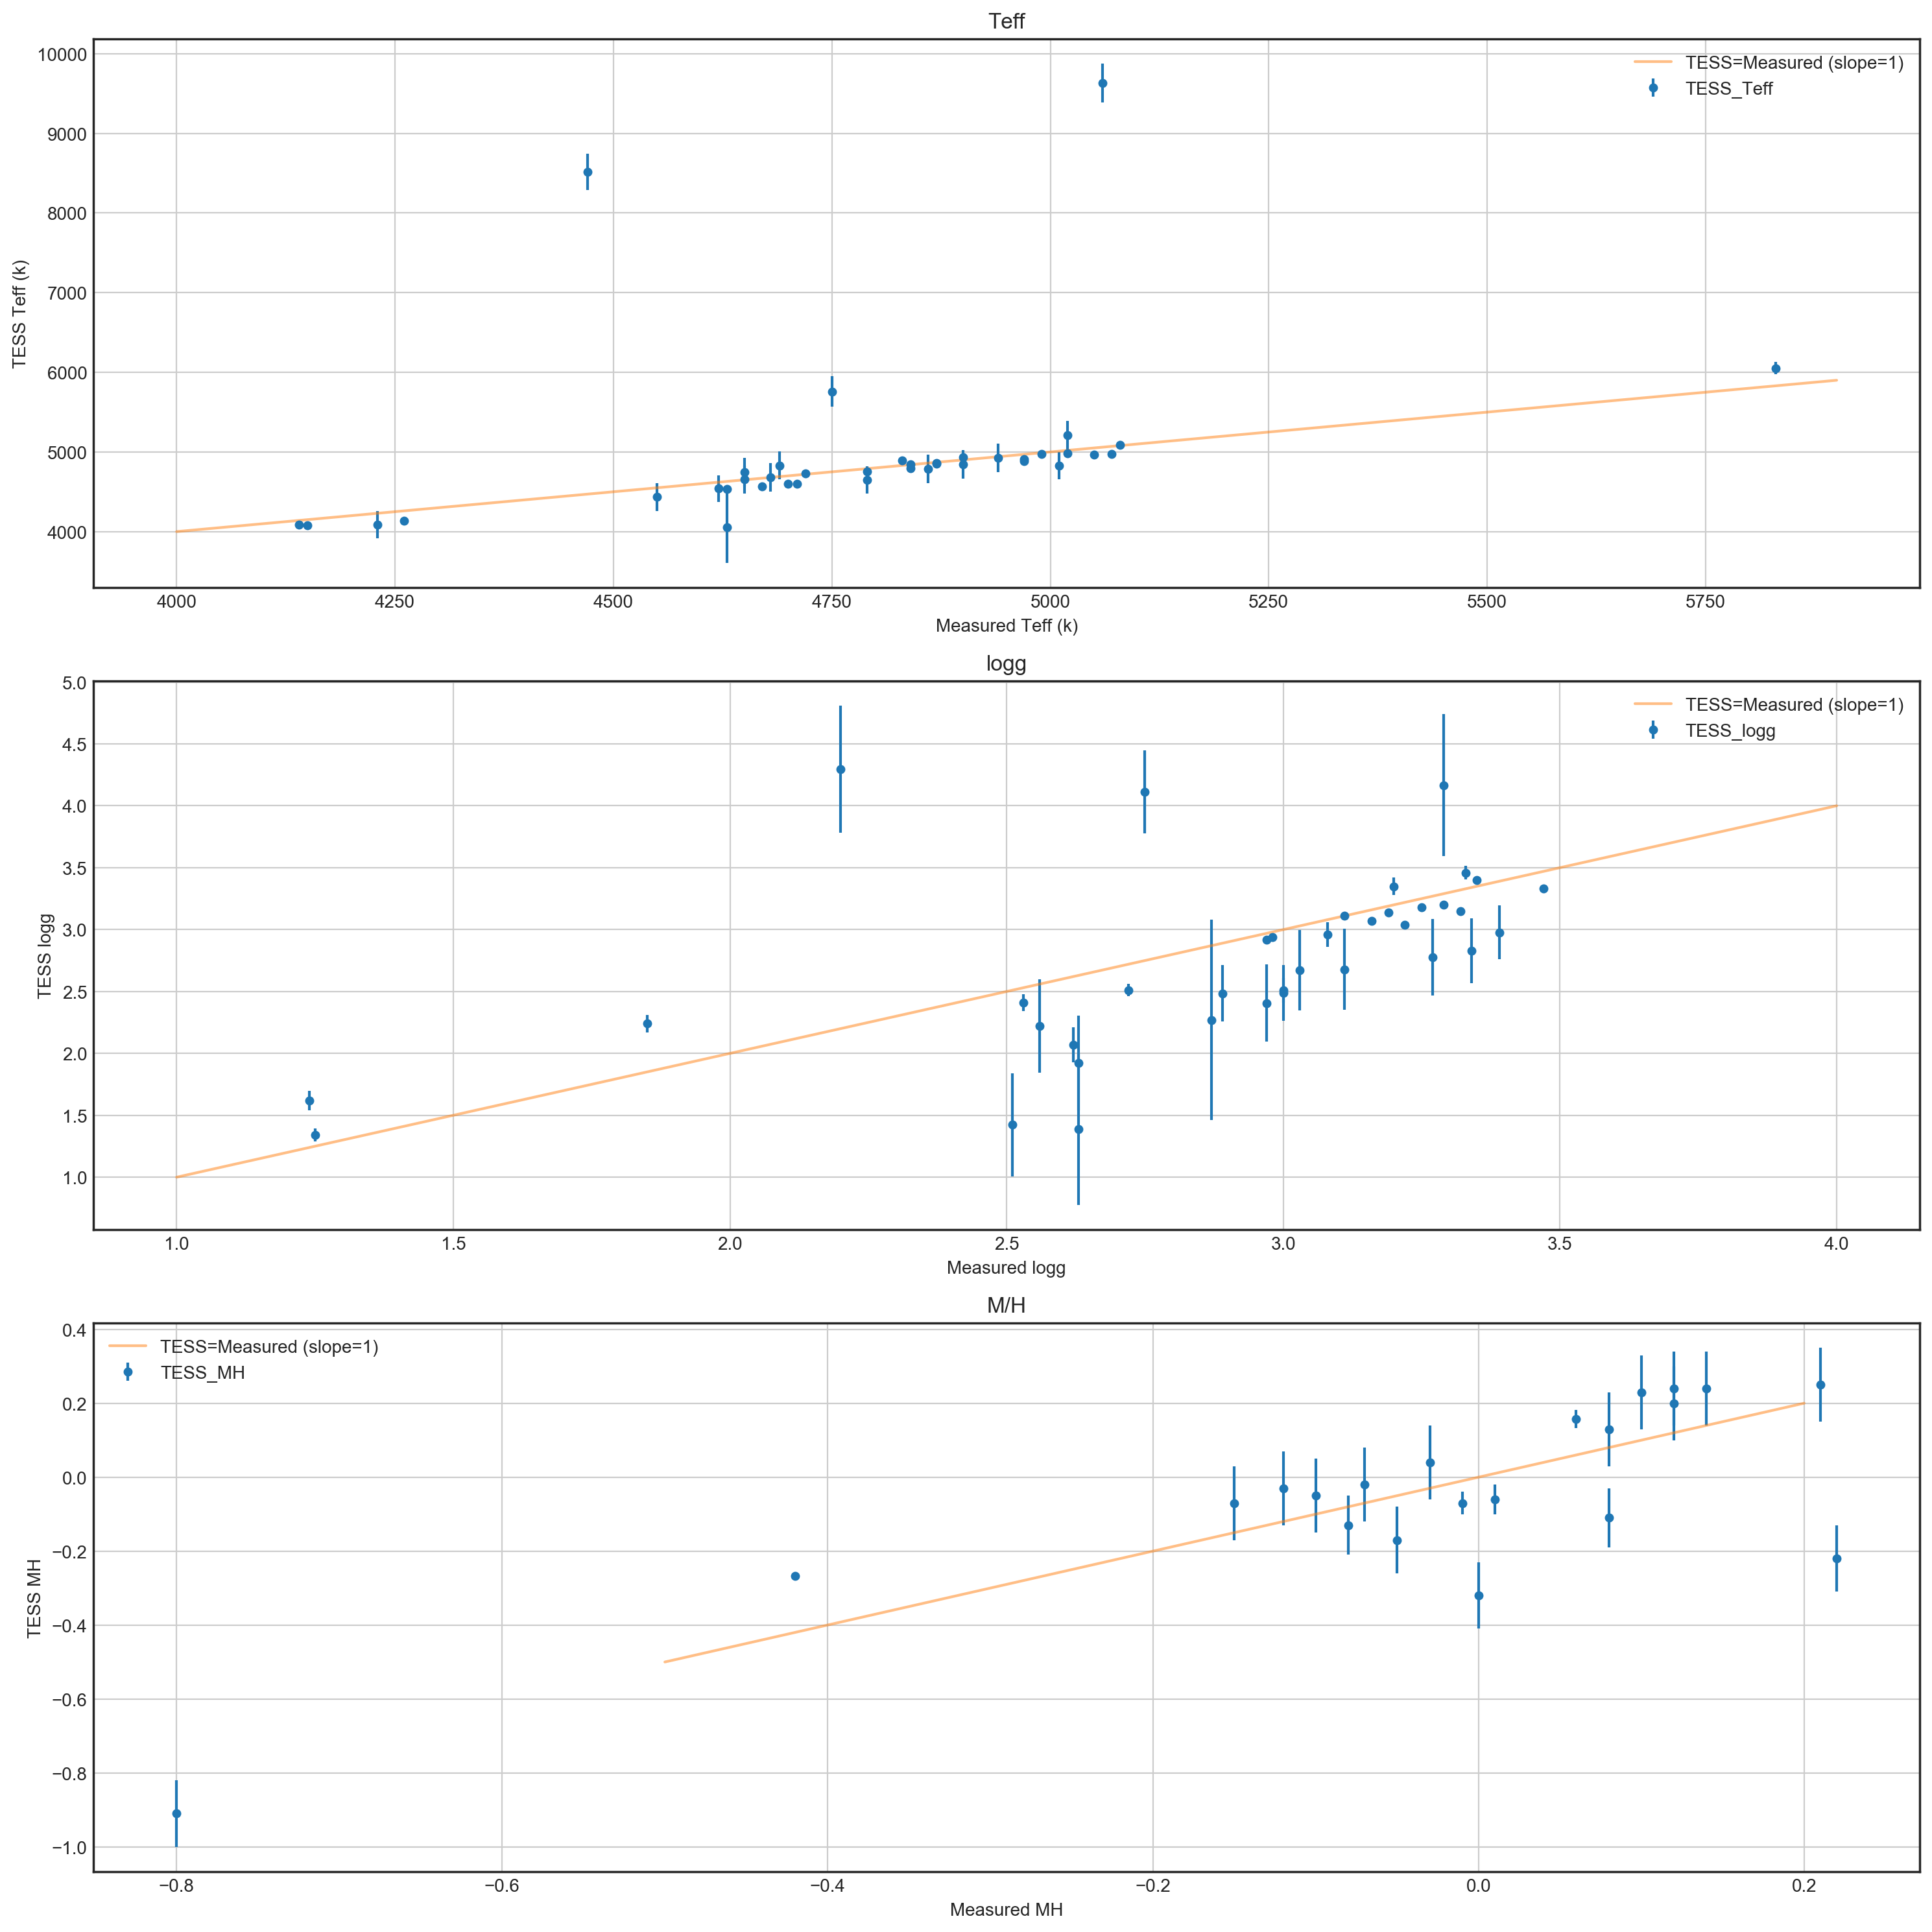

In [10]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,15), dpi = 200)


ax1.errorbar(teff_df['meas_Teff'], teff_df['TESS_Teff'],teff_df['TESS_e_Teff'],fmt='.', markersize=8)
ax1.set_title("Teff")
ax1.set_ylabel("TESS Teff (k)")
ax1.set_xlabel("Measured Teff (k)")
#ax1.set_ylim(3500,6500)
x = np.arange(4000, 6000, 100)
y = x
ax1.plot(x,y, alpha=0.5, label="TESS=Measured (slope=1)")
ax1.grid()
ax1.legend()

ax2.errorbar(logg_df['meas_logg'], logg_df['TESS_logg'],logg_df['TESS_e_logg'],fmt='.', markersize=8)
ax2.set_title("logg")
ax2.set_ylabel("TESS logg")
ax2.set_xlabel("Measured logg")
x = np.arange(1., 4.1, 1.)
y = x
ax2.plot(x,y, alpha=0.5, label="TESS=Measured (slope=1)")
ax2.grid()
ax2.legend()

ax3.errorbar(MH_df['meas_MH'], MH_df['TESS_MH'],MH_df['TESS_e_MH'],fmt='.', markersize=8)
ax3.set_title("M/H")
ax3.set_ylabel("TESS MH")
ax3.set_xlabel("Measured MH")
x = np.arange(-0.5, 0.3, 0.1)
y = x
ax3.plot(x,y, alpha=0.5, label="TESS=Measured (slope=1)")
ax3.grid()
ax3.legend()

plt.tight_layout()

#HD 39079 and HD 96036 are A type stars? Way too hot, maybe biting on the wrong stars here from the IDs?

## Astroseismic Surface Gravities from TESS Sector Light Curves

In [11]:
mask = [len(sectors) != 0 for sectors in np.array(comp_df['TESS_sectors'])]
tess_df = comp_df[mask]
tess_df

,TIC,TESS_sectors,TESS_cameras,TESS_ccds,meas_Teff,TESS_Teff,TESS_e_Teff,meas_logg,TESS_logg,TESS_e_logg,meas_MH,TESS_MH,TESS_e_MH
24Sex,1713457,[8],[1],[3],5020.0,5098,--,3.40,3.24556,--,0.00,--,--
7CMa,48237215,[6],[2],[2],4790.0,4792,--,3.21,3.89682,--,0.19,--,--
81Cet,35725282,[4],[1],[4],4900.0,4785,--,2.89,2.73585,--,0.03,--,--
HD11977,232074535,"[1, 2]","[3, 3]","[4, 3]",4980.0,4970,--,2.76,2.71168,--,-0.18,--,--
HD1690,37763102,[3],[1],[4],4370.0,4393,--,1.91,2.03042,--,-0.30,--,--
HD17311,36820777,[4],[1],[1],5020.0,4980,25,3.47,3.33,0.028,-0.10,-0.05,0.1
HD18742,71345433,[4],[2],[4],4990.0,5048,--,3.17,3.26216,--,-0.13,--,--
HD19138,365301667,[4],[1],[3],4230.0,4090,171,1.75,--,--,-0.38,--,--
HD19810,9804284,[4],[1],[2],4860.0,4786,178,3.27,2.7769,0.310492,-0.07,--,--
HD20924,406475297,[4],[2],[3],4680.0,4683,177,3.00,2.48795,0.223661,0.06,--,--


In [93]:
# Get light curves from known TICs (not all sectors have been observed currently)
for TIC in tess_df['TIC']:
    search_results = lightkurve.search.search_lightcurvefile(TIC, mission='TESS')
    if len(search_results) > 0:
        search_results.download_all(download_dir = "/Users/dbranton/redgiant_planethosts/astroseismic/data/")

No data found for target "35725282".
No data found for target "232074535".
No data found for target "406500991".
No data found for target "244256625".


In [12]:
# Glob in the TESS lightcurves

lcfs = glob.glob("/Users/dbranton/redgiant_planethosts/astroseismic/data/mastDownload/TESS/*/*")

nu_max = 274.5
T_eff = 3796.11
nu_max_sol = 3140.
T_sol = 5777.
g_sun = const.G.cgs*const.M_sun.cgs/(const.R_sun.cgs)**2

def logg_to_nu_max(logg,temp):
    g_obs = 10**logg
    nu_max_exp2 = nu_max_sol*g_obs/g_sun.value * np.sqrt(T_sol/temp)
    return nu_max_exp2

def nu_max_to_logg(nu_max,temp):
    g_obs = g_sun.value*(nu_max/nu_max_sol)*np.sqrt(temp/T_sol)
    return np.log10(g_obs)

print(logg_to_nu_max(2.91, 5067)) #Exoplanets.org value
print(logg_to_nu_max(2.76, 4980)) # Our values


print(nu_max_to_logg(56.0, 5067)) # exoplanet's.org temp
print(nu_max_to_logg(56.0, 4980))# using our temp

99.38886987852419
70.97387759322397
2.660850274610748
2.6570894938452714


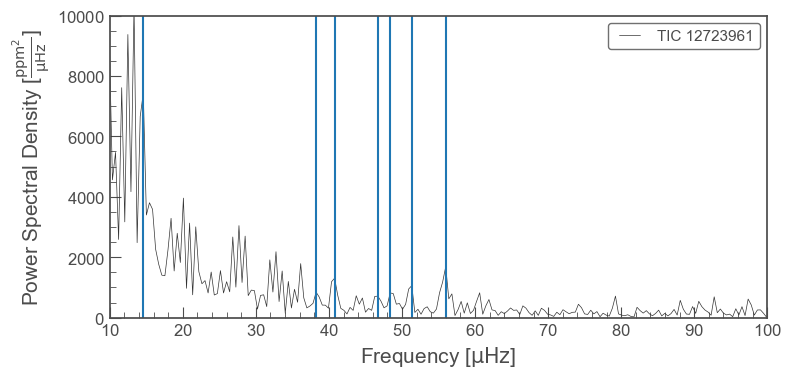

In [100]:
for lcf in lcfs[1:2]:
    match_df = tess_df.loc[tess_df['TIC'] == str(int(lcf.split("/")[-1].split("-")[2]))]
    #print(float(match_df["TESS_logg"]), float(match_df["TESS_Teff"])) #MAST value
    #print(float(match_df["meas_logg"]), float(match_df["meas_Teff"]))
    nu_max_lc = logg_to_nu_max(float(match_df["meas_logg"]), float(match_df["meas_Teff"])) #measured value
    #print(nu_max_lc)
    lc = lightkurve.open(lcf).SAP_FLUX
    per3=lc.remove_nans().fill_gaps().to_periodogram(minimum_period=5*u.minute,oversample_factor=10,normalization='psd').bin(binsize=10)
    per3.plot(unit=u.microHertz,scale='linear')
    #print(per3.frequency_at_max_power)
    peaks = find_peaks(per3.power, width = 2, height=700)[0]
    #print(len(peaks))
    for peak in peaks:
        plt.axvline(per3.frequency[peak].value)
    plt.xlim(10,100)
    plt.ylim(1,1e4)
    plt.axvline(nu_max_lc, color='g')
    #print(f"{float(match_df['TIC'])}: Nu Max = {nu_max_lc}, Measured Teff = {float(match_df['meas_Teff'])}, Measured Logg = {float(match_df['meas_logg'])}")
    